In [1]:
from os.path import join
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import gaussian_filter
import torch
import torch.nn.functional as F

In [2]:
def pad_attention(attention_tensors):
    max_tokens = max([tensor.shape[2] for tensor in attention_tensors])
    max_seq_len = max([tensor.shape[-1] for tensor in attention_tensors])
    all_tensors = []
    for tensor in attention_tensors:
        token_padding = max_tokens-tensor.shape[2]
        seq_padding = max_seq_len-tensor.shape[-1]
        padded_tensor = F.pad(tensor, 
                              (0, token_padding, 0, seq_padding), 
                              value=float('nan'))
        all_tensors.append(padded_tensor)
    return torch.cat(all_tensors)

def load_attention(model_name, task_name):
    output_dir = f'/scratch/gpfs/JDC/declan/probing/output/{task_name}/{model_name}/activations/attn-*'
    layer_paths = sorted(glob(output_dir), key=lambda x: int(x.split('-')[-1]))
    layer_attentions = []
    for layer_path in layer_paths:
        layer_path = join(layer_path, '*.pt')
        chunks = [torch.load(chunk_path, 
                             weights_only=True, 
                             map_location='cpu') for chunk_path in glob(layer_path)]
        layer_attentions.append(pad_attention(chunks))
    return torch.stack(layer_attentions)

def load_metadata(model_name, task_name):
    metadata_dir = f'/scratch/gpfs/JDC/declan/probing/output/{task_name}/{model_name}'
    response_path = join(metadata_dir, 'model_responses.csv')
    mask_path = join(metadata_dir, 'image_mask.pt')
    response_df = pd.read_csv(response_path)
    image_mask = torch.load(mask_path, weights_only=True, map_location='cpu')
    return response_df, image_mask

def load(model_name, layer_name, token_mean=True):
    # Load task metadata and attention weight
    response_df, image_mask = load_metadata(model_name, task_name)
    attention_weights = load_attention(model_name, task_name)

    # Pad the attention masks
    mask_padding = attention_weights.shape[-1] - image_mask.shape[-1]
    padded_mask = F.pad(image_mask, (0, mask_padding), value=False)

    # Get the attention maps for each layer
    all_attn_maps = []
    for layer_idx, layer_attn in enumerate(attention_weights):
        print(layer_idx)
        if token_mean:
            layer_attention = attention_weights[layer_index].nanmean((1,2)) # average across layers and tokens
        else:
            layer_attention = attention_weights[layer_index, :, 0].nanmean(1) # average only the layers 
        masked_attention = layer_attention[padded_mask].reshape(layer_attention.shape[0], -1)
        attention_maps = masked_attention[:, 1:-1].reshape(-1,18,18).to(torch.float32).numpy()
        attention_maps = np.repeat(np.repeat(attention_maps, 4, axis=1), 4, axis=2)
        attention_maps = gaussian_filter(attention_maps, sigma=4)
        all_attn_maps.append(all_attn_maps)
    return response_df, np.concatenate(all_attn_maps)

In [3]:
model_name = 'qwen'
task_name = 'search'

#response_df, all_attn_maps = load(model_name, task_name)

# Load task metadata and attention weight
response_df, image_mask = load_metadata(model_name, task_name)
attention_weights = load_attention(model_name, task_name)

# Pad the attention masks
mask_padding = attention_weights.shape[-1] - image_mask.shape[-1]
padded_mask = F.pad(image_mask, (0, mask_padding), value=False)

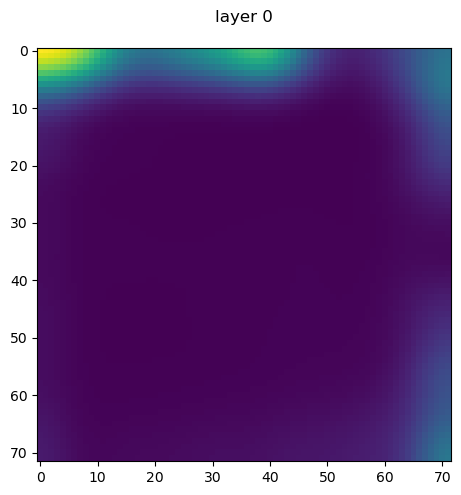

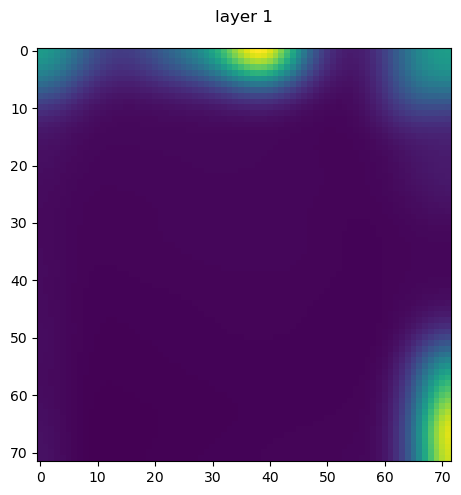

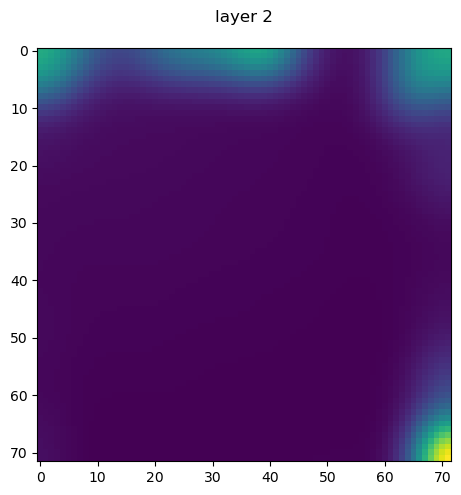

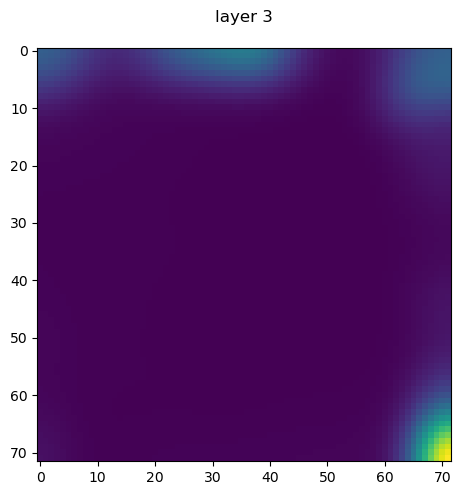

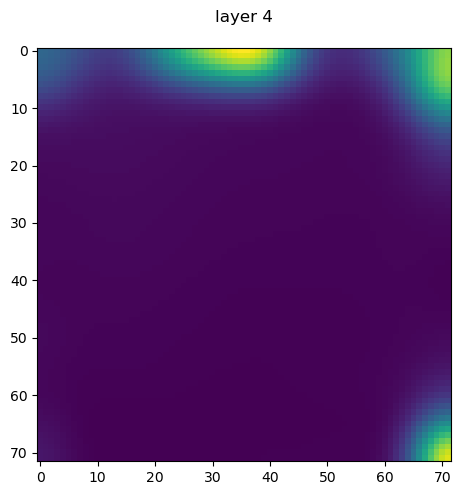

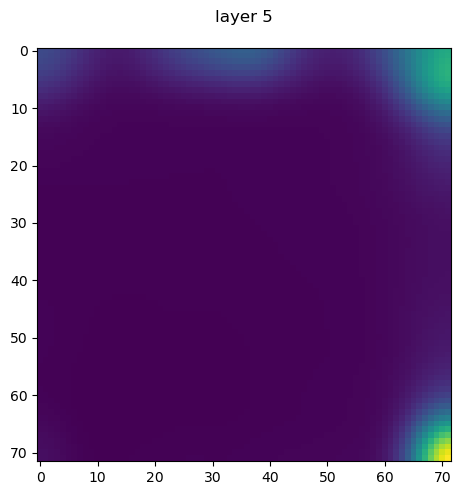

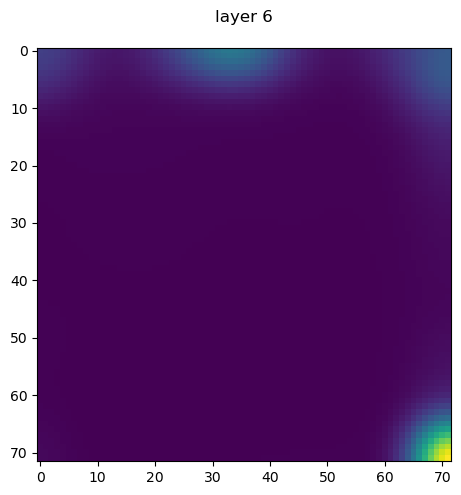

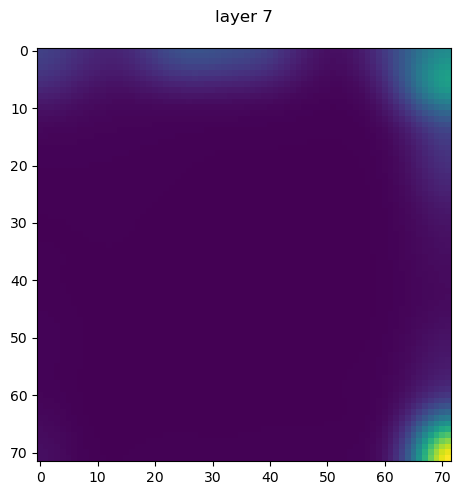

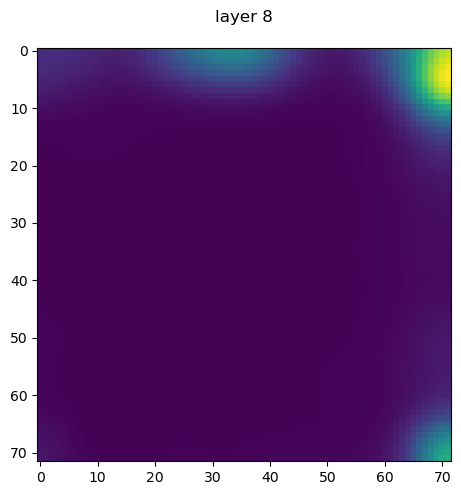

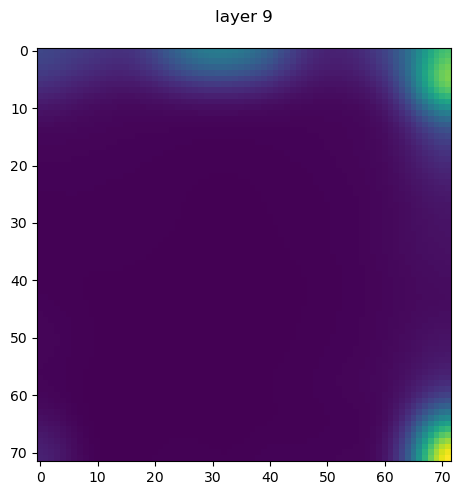

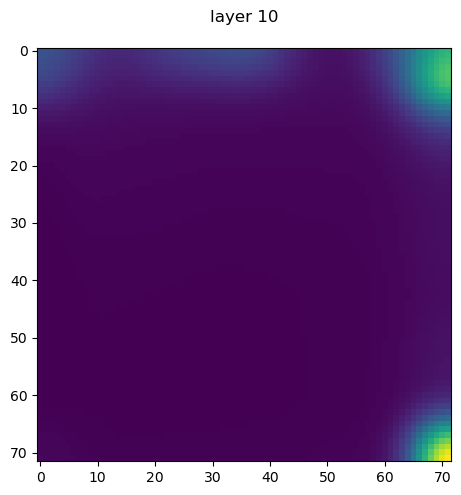

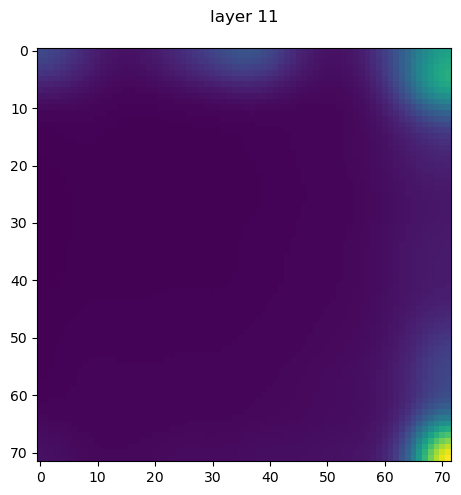

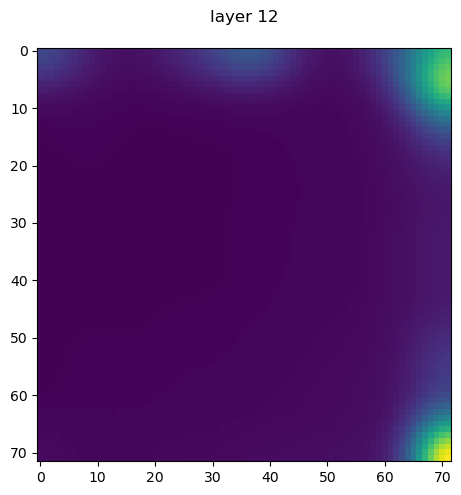

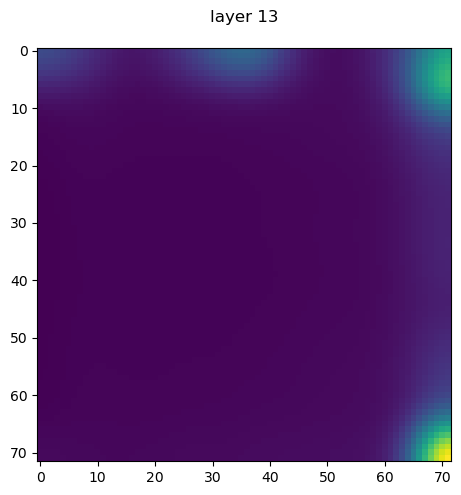

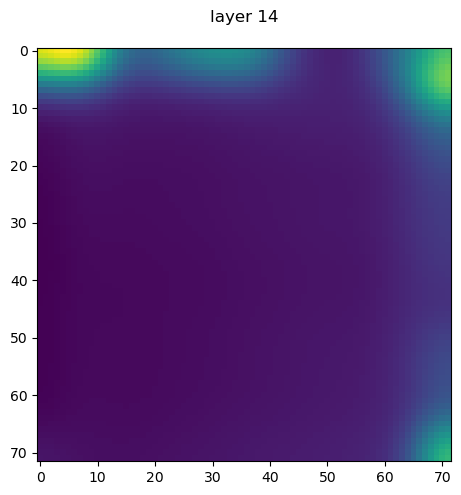

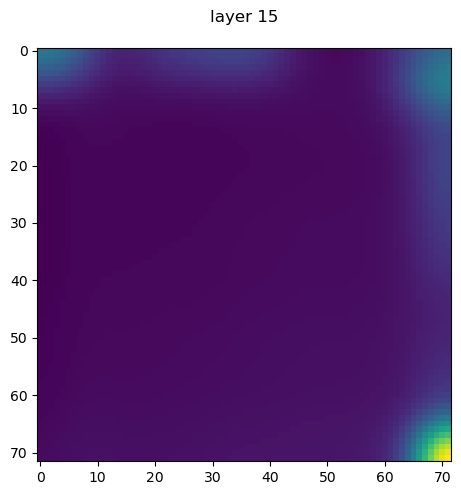

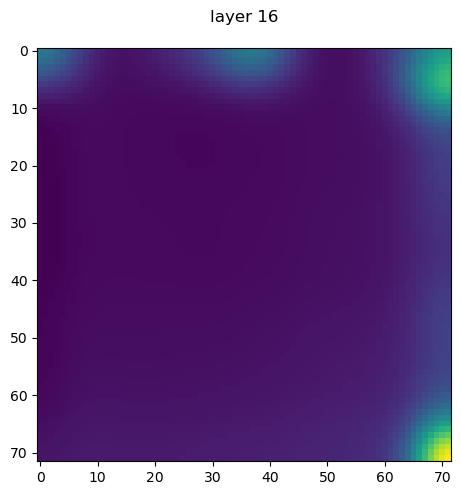

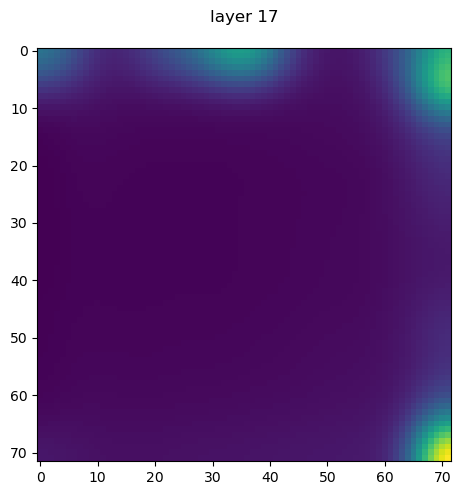

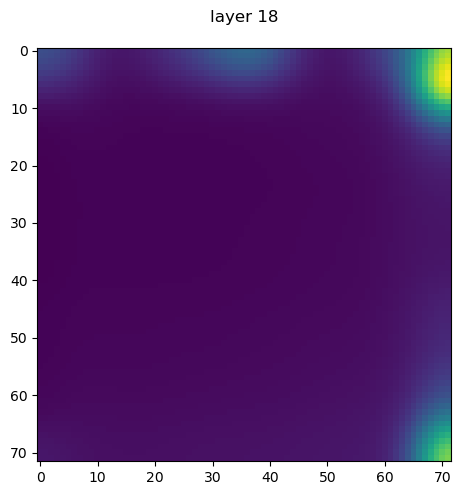

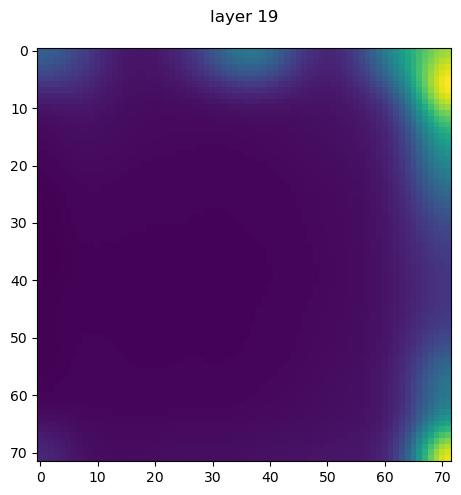

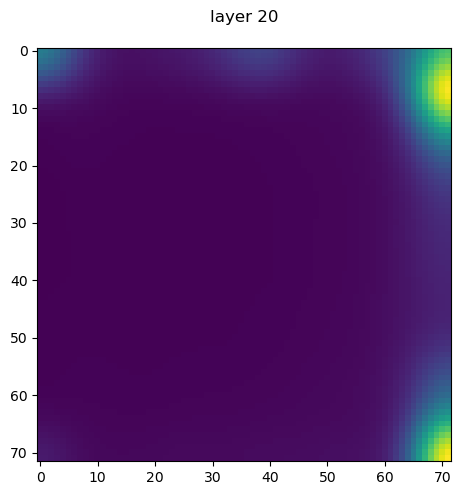

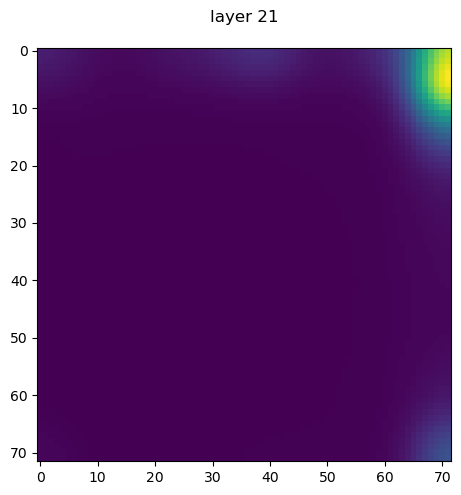

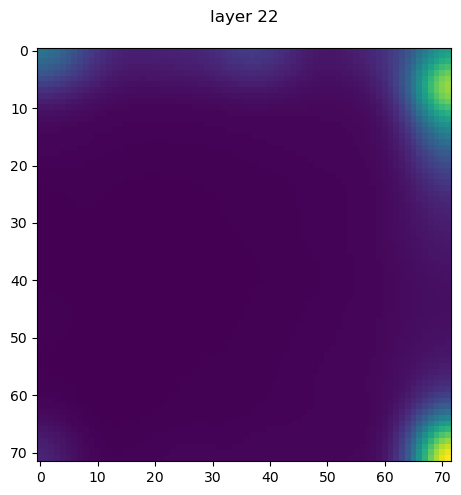

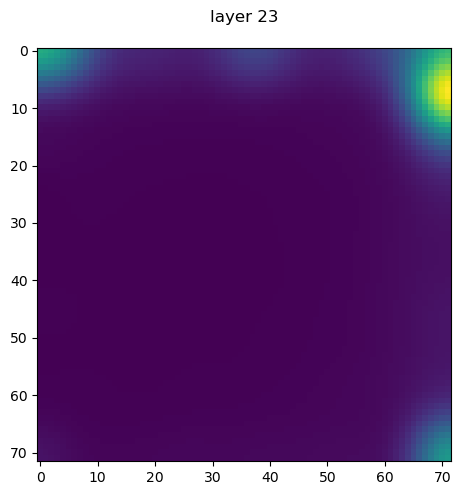

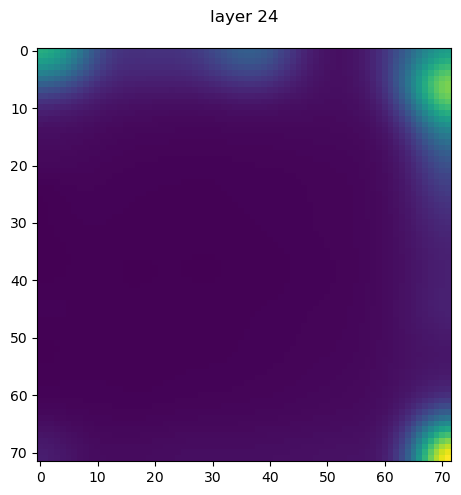

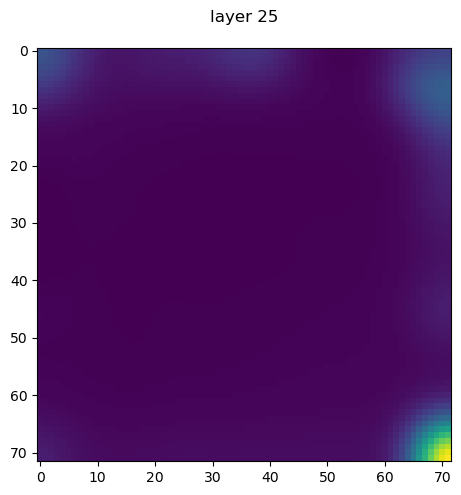

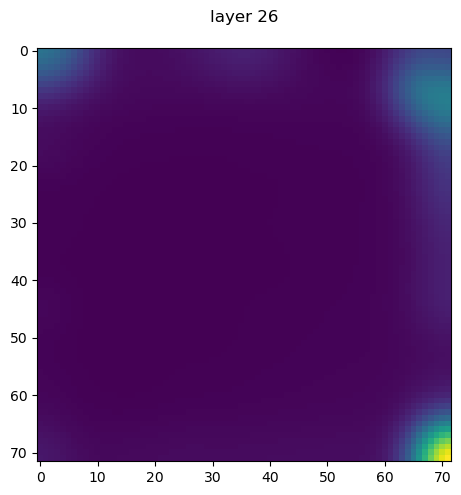

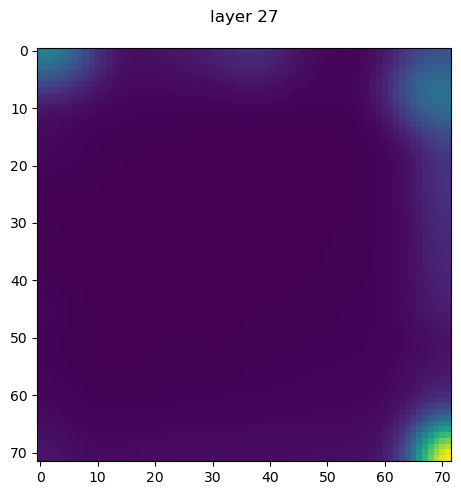

: 

In [ ]:
disjunctive_df = response_df[response_df.search_type=='disjunctive']
conjunctive_df = response_df[response_df.search_type=='conjunctive']

for layer_idx, layer_attn in enumerate(attention_weights):
    layer_attention = layer_attn[:, :, 0].nanmean(1) # average only the layers 
    masked_attention = layer_attention[padded_mask].reshape(layer_attention.shape[0], -1)
    attention_maps = masked_attention[:, 1:-1].reshape(-1,18,18).to(torch.float32).numpy()
    attention_maps = np.repeat(np.repeat(attention_maps, 4, axis=1), 4, axis=2)
    attention_maps = gaussian_filter(attention_maps, sigma=4)

    # plot the results
    fig, ax = plt.subplots(1,1, figsize=(10,5), tight_layout=True)
    ax.imshow(attention_maps.mean(0))
    fig.suptitle(f'layer {layer_idx}')
    plt.show()

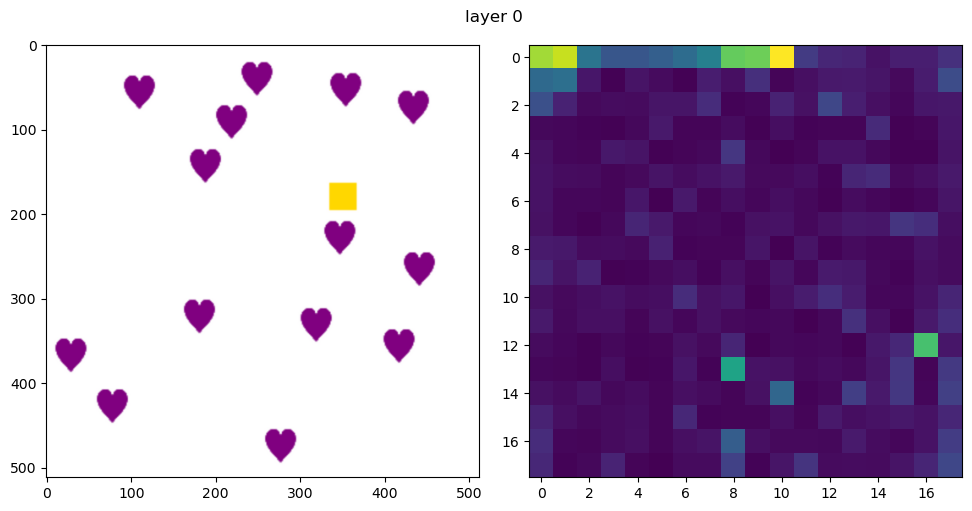

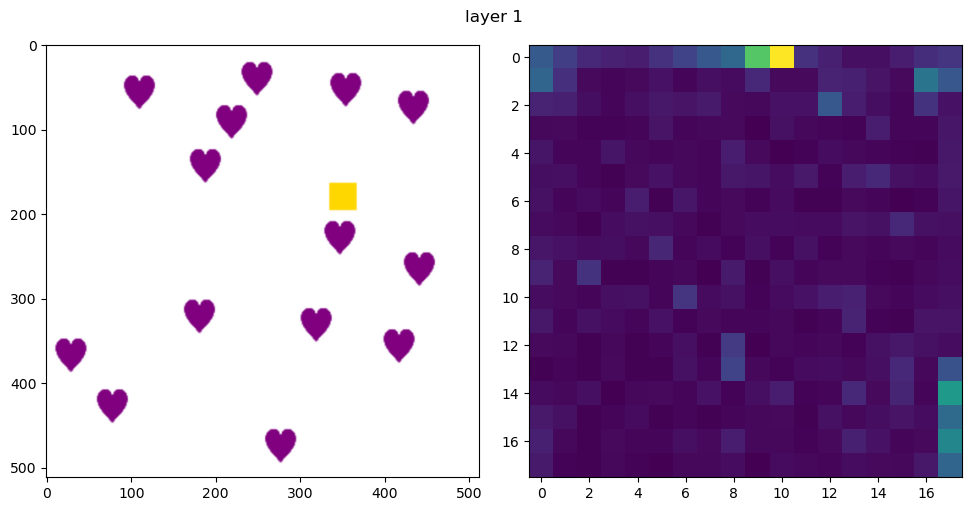

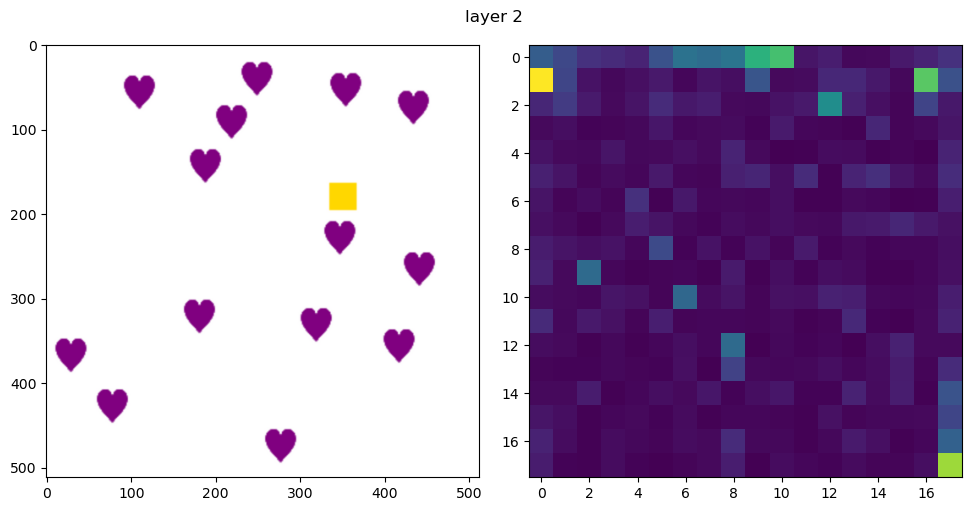

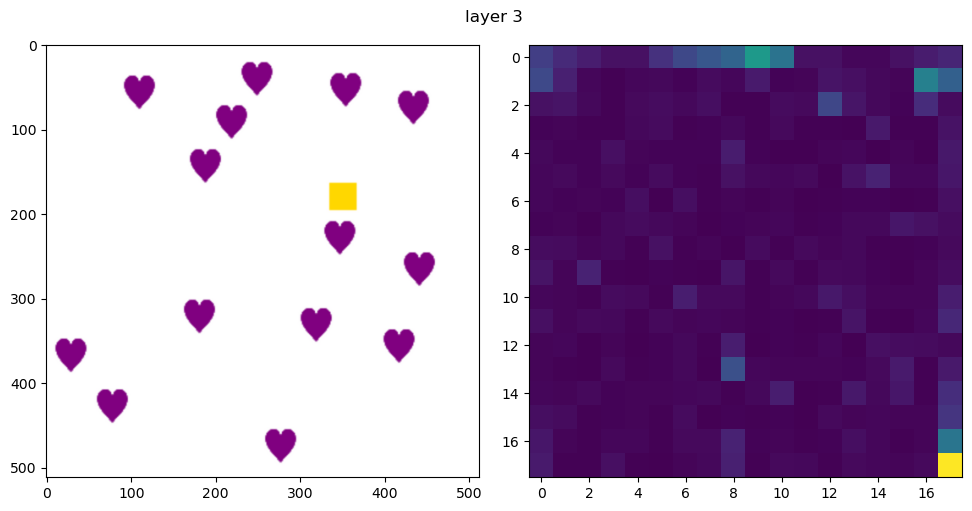

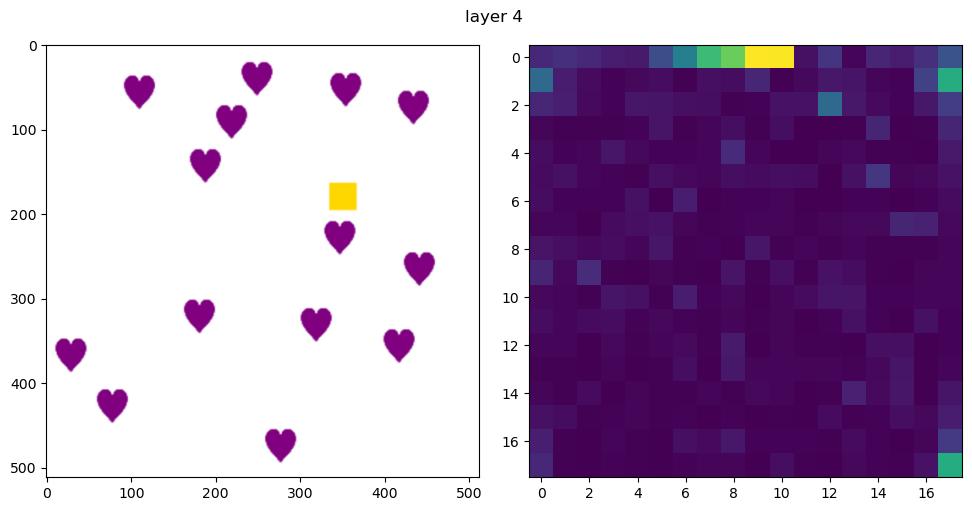

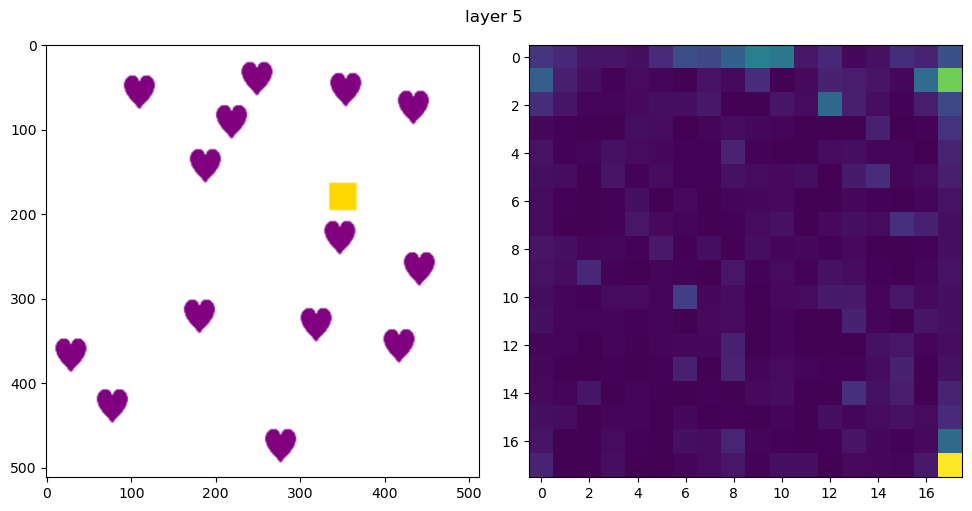

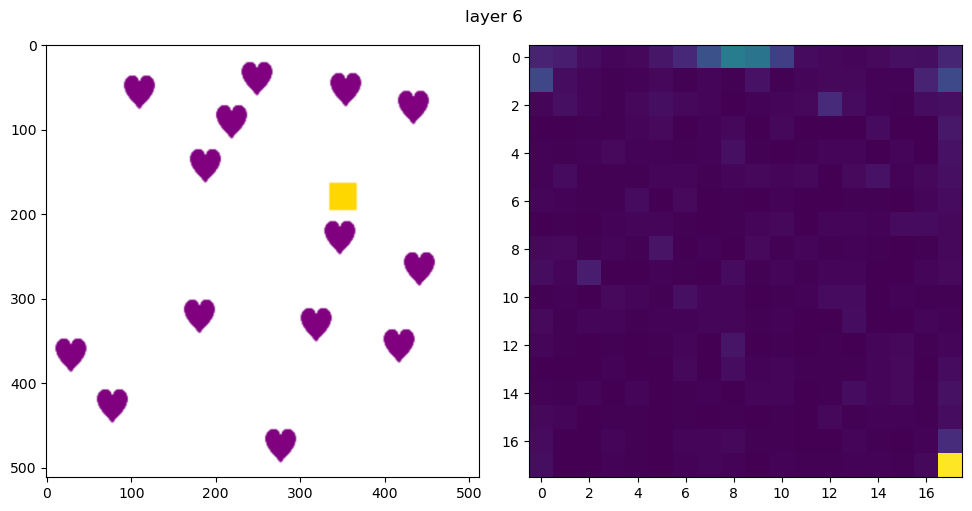

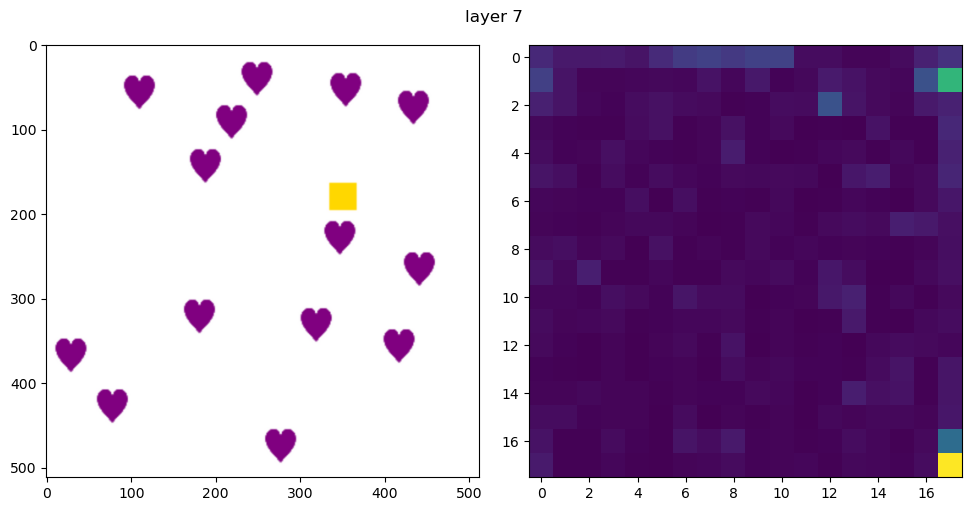

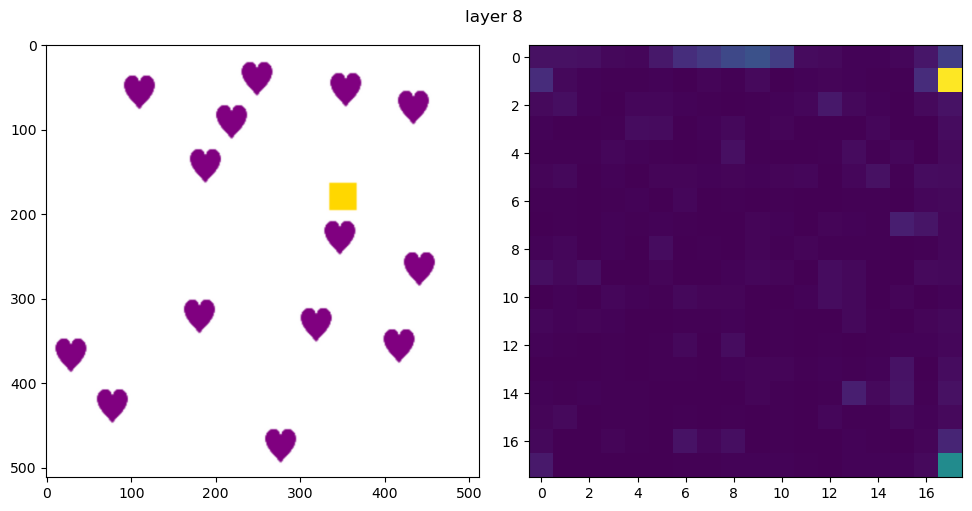

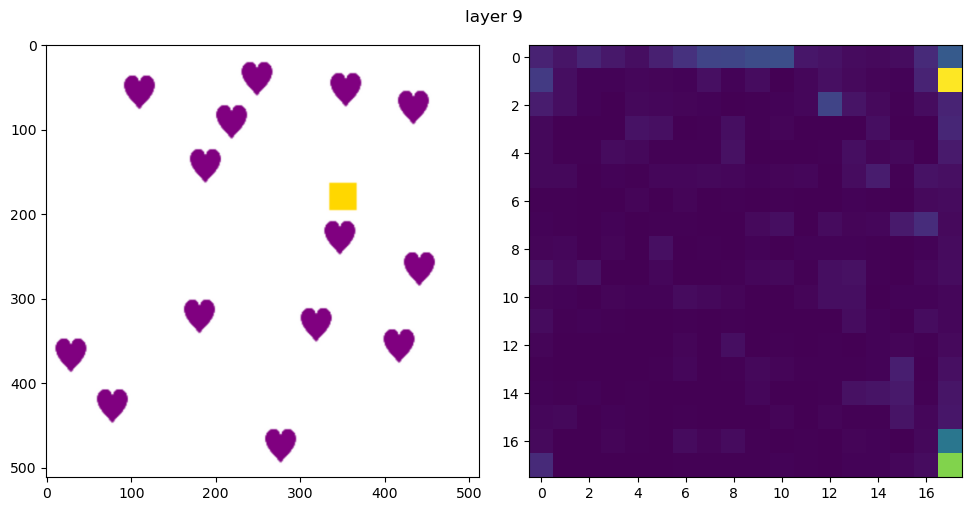

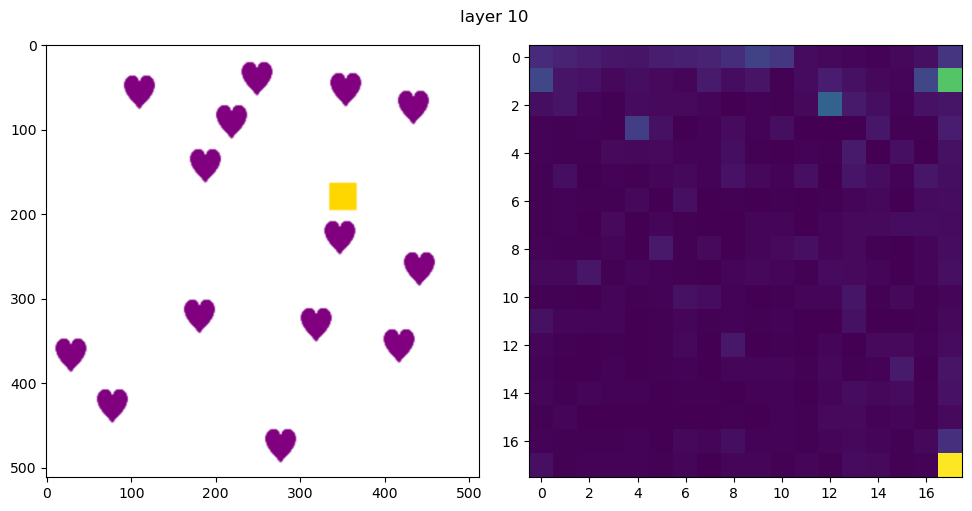

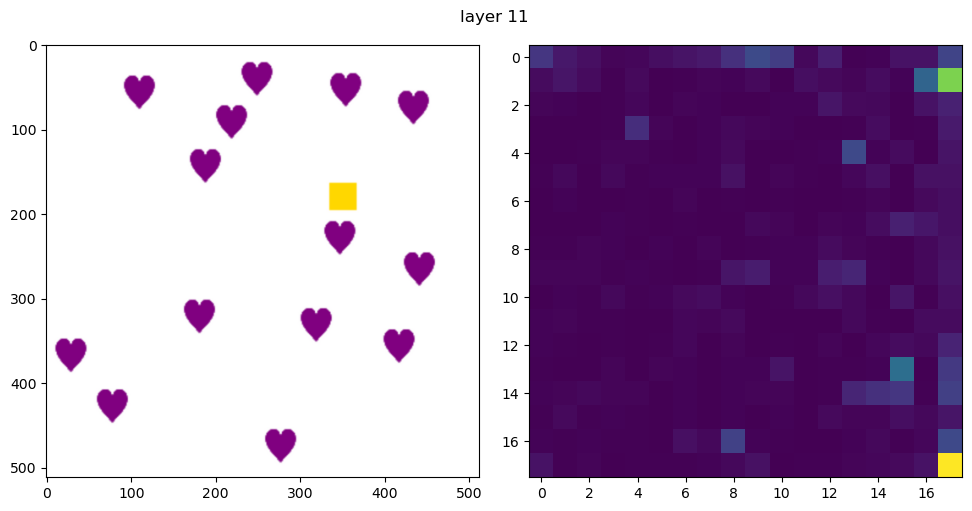

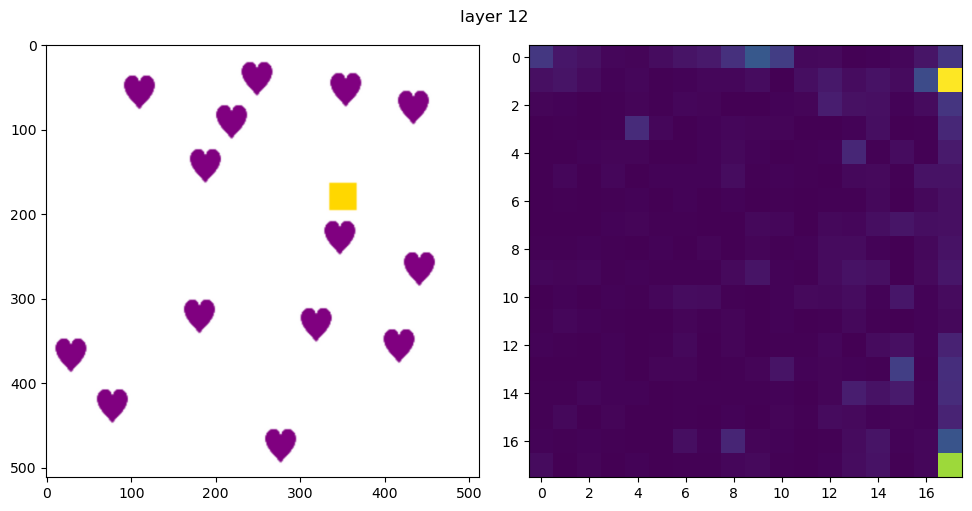

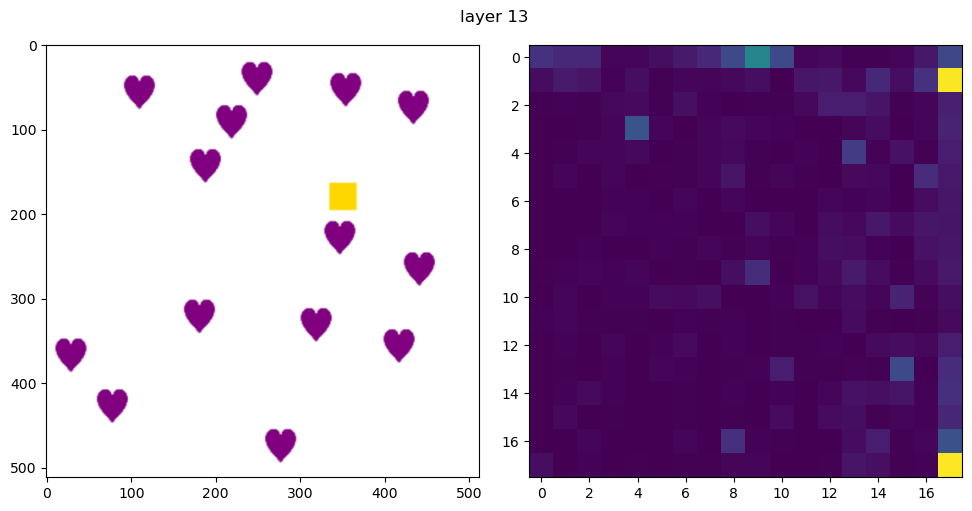

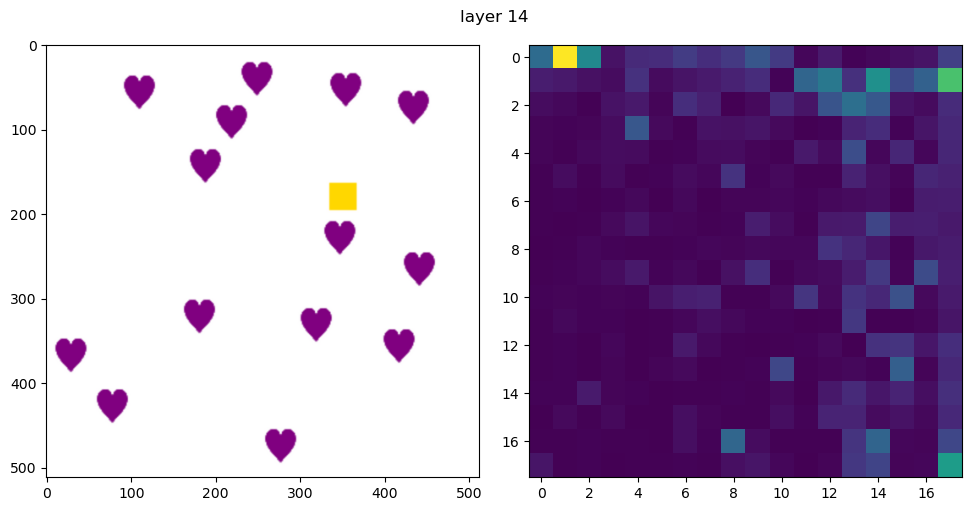

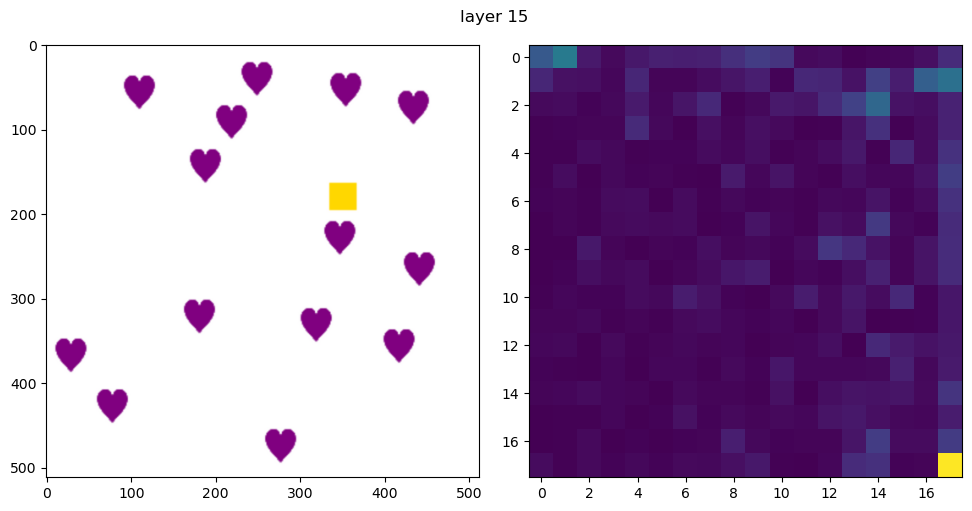

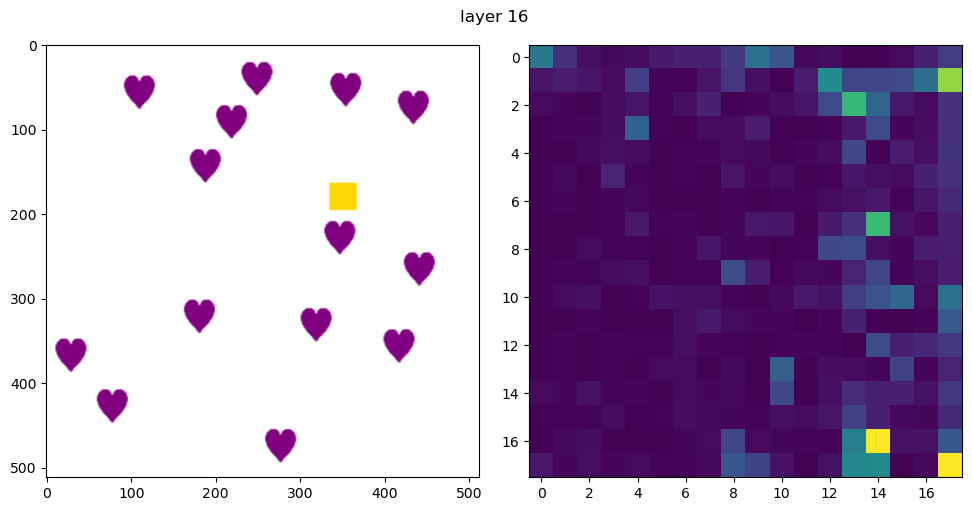

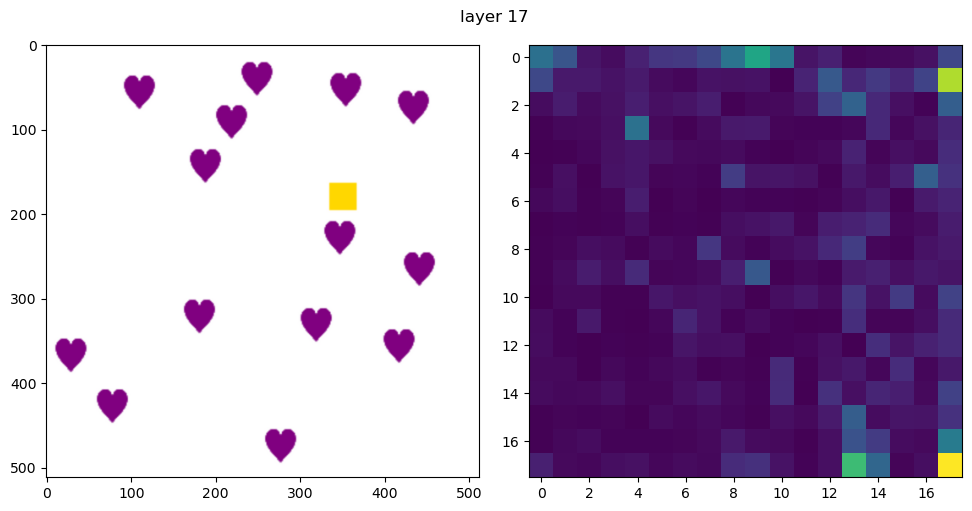

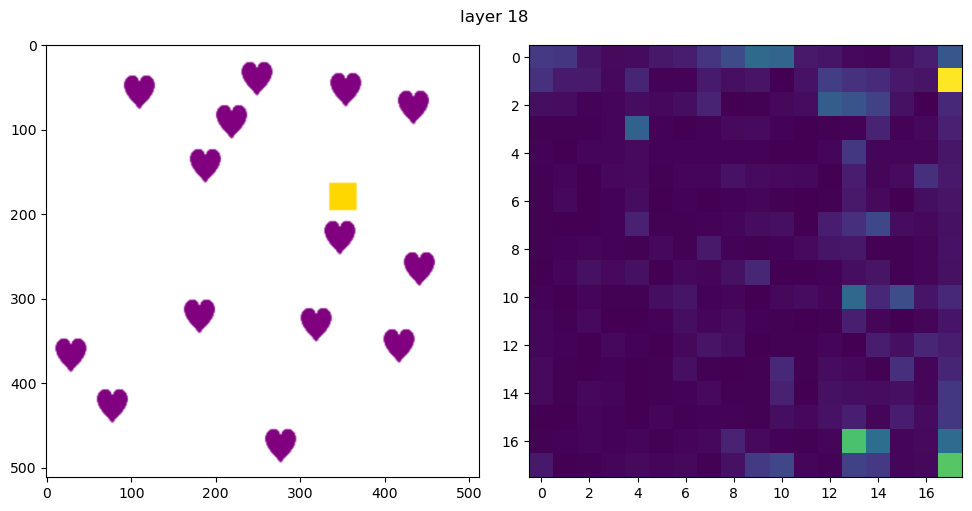

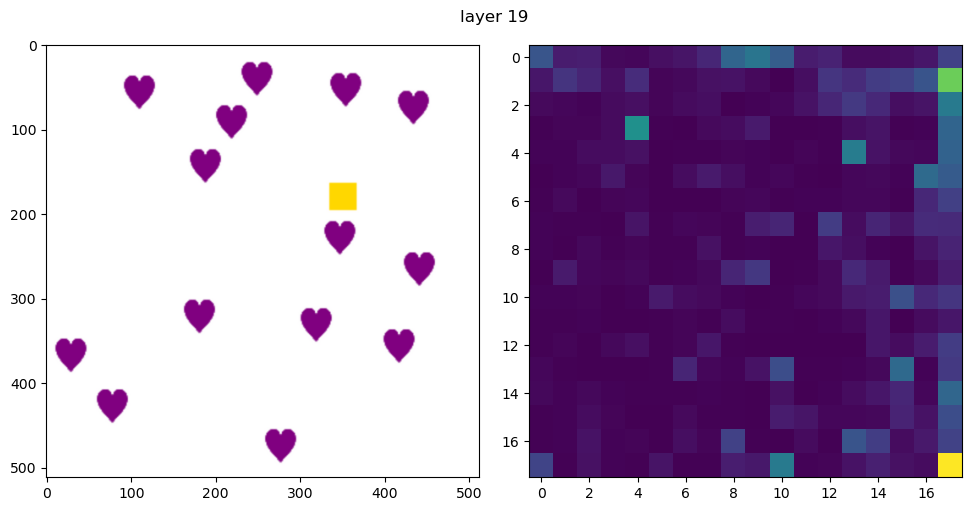

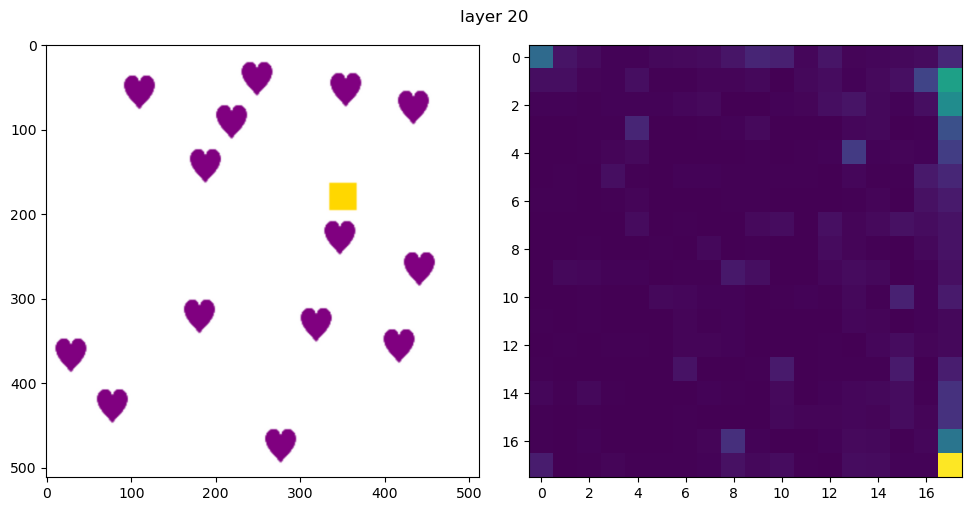

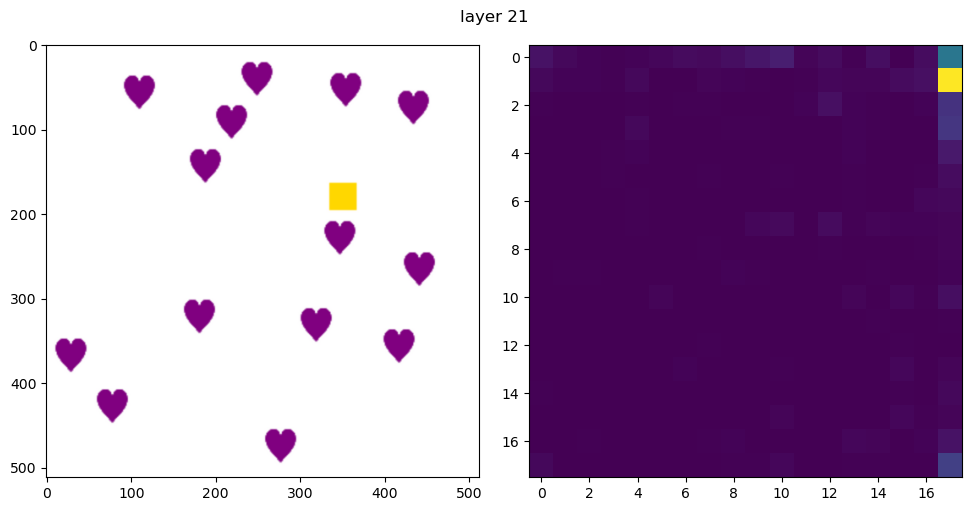

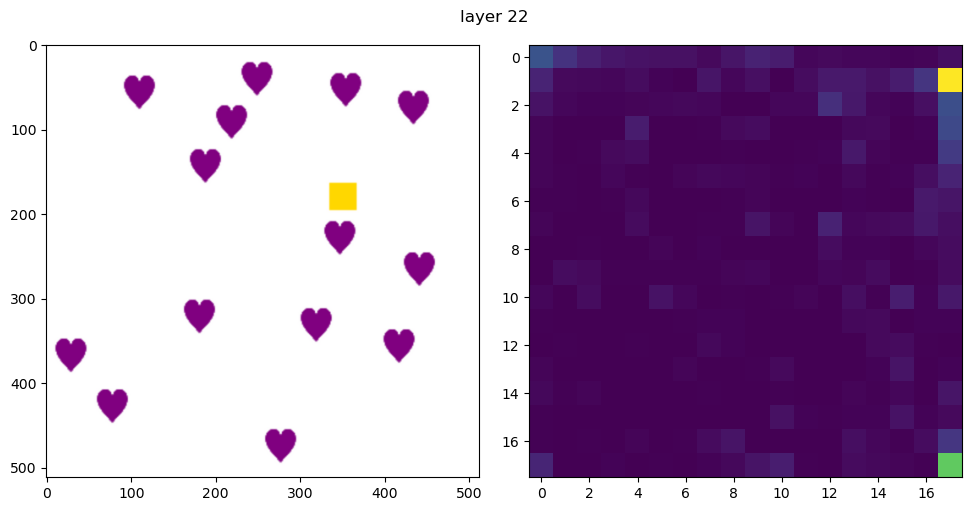

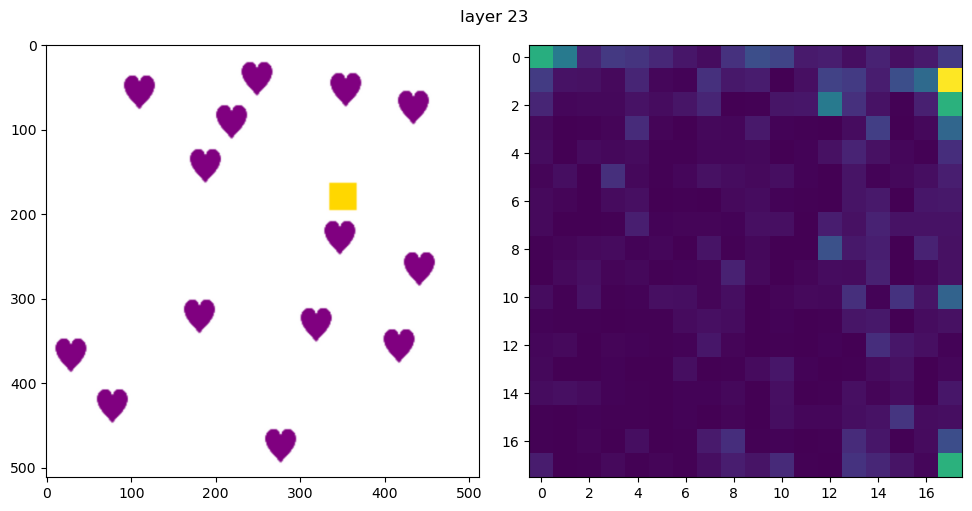

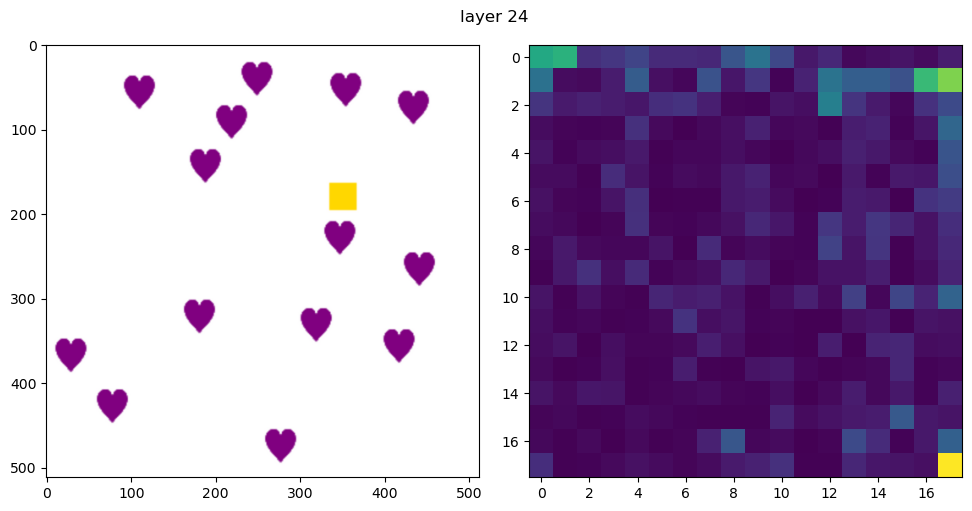

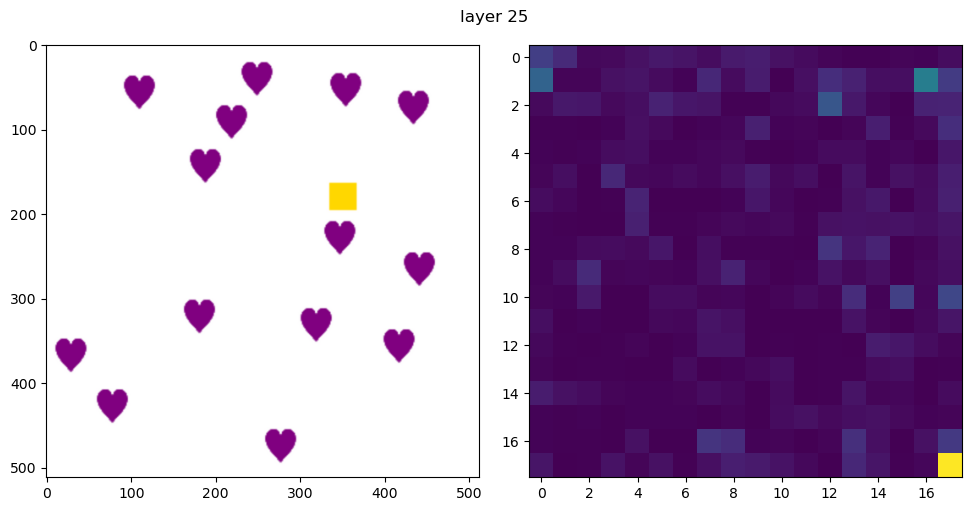

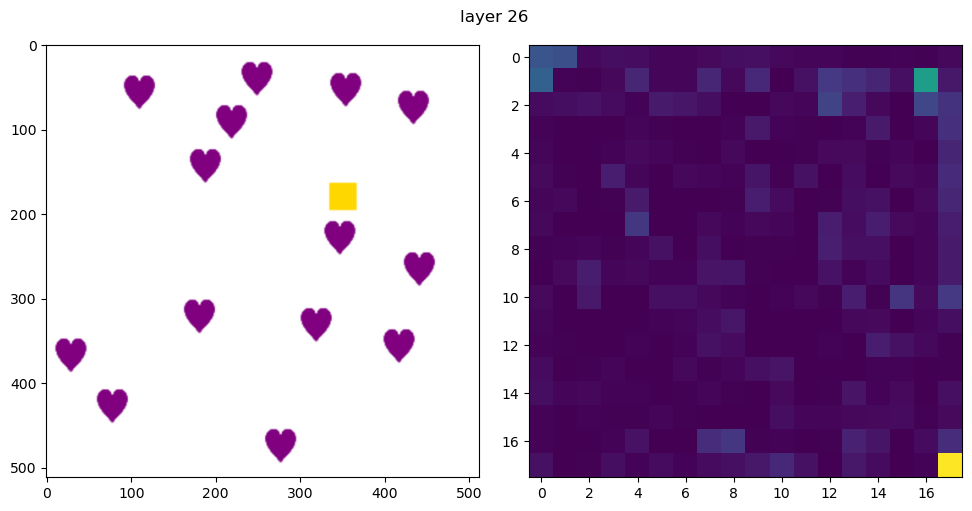

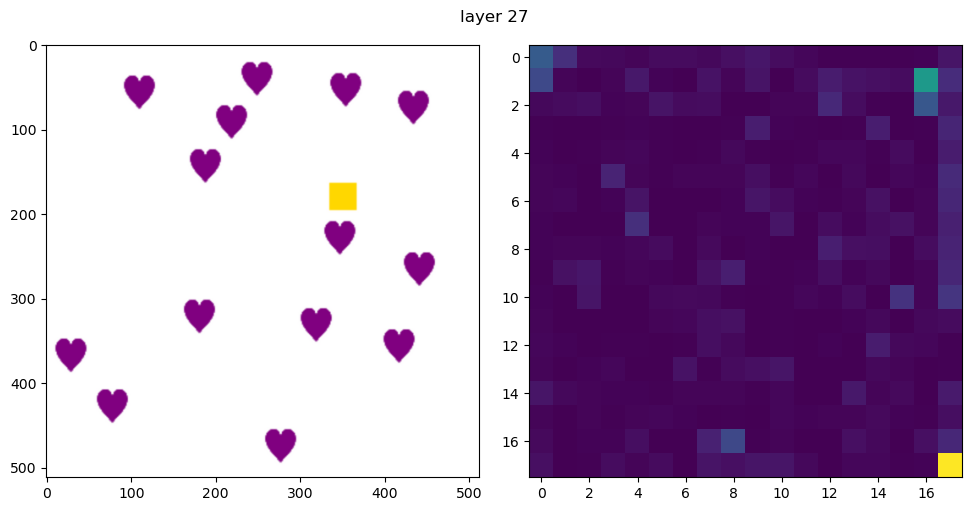

: 

In [ ]:
response_df = response_df[response_df.search_type=='disjunctive']
trial = response_df.sample(1)
image = Image.open(trial.path.item())
token_mean = False

for layer_idx, layer_attn in enumerate(attention_weights):
    if token_mean:
        layer_attention = layer_attn.nanmean((1,2)) # average across layers and tokens
    else:
        layer_attention = layer_attn[:, :, 0].nanmean(1) # average only the layers 
    masked_attention = layer_attention[padded_mask].reshape(layer_attention.shape[0], -1)
    attention_maps = masked_attention[:, 1:-1].reshape(-1,18,18).to(torch.float32).numpy()
    #attention_maps = np.repeat(np.repeat(attention_maps, 4, axis=1), 4, axis=2)
    #attention_maps = gaussian_filter(attention_maps, sigma=4)

    # plot the results
    fig, axes = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
    axes[0].imshow(image)
    axes[1].imshow(attention_maps[trial.index[0]])
    fig.suptitle(f'layer {layer_idx}')
    plt.show()

In [ ]:
trial = response_df.sample(1)
image = Image.open(trial.path.item())

for i, layer in enumerate(all_attn_maps):
    fig, axes = plt.subplots(1,2, figsize=(10,5), tight_layout=True)
    axes[0].imshow(image)
    axes[1].imshow(attention_maps[trial.index[0]])
    fig.suptitle(f'layer {i}')
    plt.show()

In [41]:
layer_index = 0
layer_attention = attention_weights[layer_index].nanmean((1,2)) # average across layers and tokens
masked_attention = layer_attention[padded_mask].reshape(layer_attention.shape[0], -1)
attention_maps = masked_attention[:, 1:-1].reshape(-1,18,18).to(torch.float32).numpy()
attention_maps = np.repeat(np.repeat(attention_maps, 4, axis=1), 4, axis=2)
attention_maps = gaussian_filter(attention_maps, sigma=4)

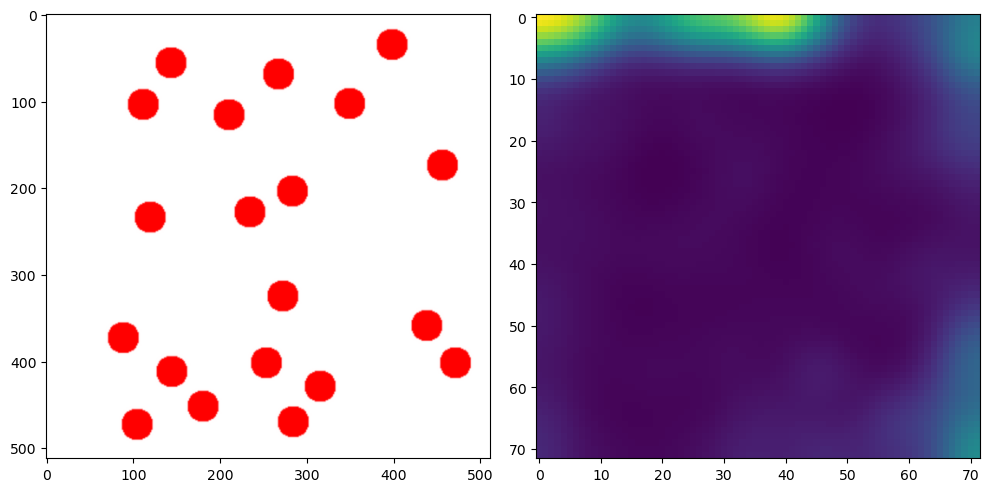

In [12]:
response_df

,path,n_objects,search_type,trial,target_color,target_shape,target_present,features,response
0,/scratch/gpfs/JDC/declan/probing/data/search/i...,5,conjunctive,0,blue,triangle,True,"[{'x': 104, 'y': 190, 'size': 45, 'color': 'bl...",Yes.
1,/scratch/gpfs/JDC/declan/probing/data/search/i...,5,conjunctive,1,gold,circle,False,"[{'x': 213, 'y': 64, 'size': 45, 'color': 'pur...",No.
2,/scratch/gpfs/JDC/declan/probing/data/search/i...,5,conjunctive,2,blue,heart,True,"[{'x': 290, 'y': 108, 'size': 45, 'color': 'bl...",Yes.
3,/scratch/gpfs/JDC/declan/probing/data/search/i...,5,conjunctive,3,red,heart,False,"[{'x': 319, 'y': 97, 'size': 45, 'color': 'blu...",Yes.
4,/scratch/gpfs/JDC/declan/probing/data/search/i...,5,conjunctive,4,red,circle,True,"[{'x': 79, 'y': 438, 'size': 45, 'color': 'red...",Yes.
...,...,...,...,...,...,...,...,...,...
3995,/scratch/gpfs/JDC/declan/probing/data/search/i...,50,disjunctive,3995,blue,circle,False,"[{'x': 271, 'y': 105, 'size': 45, 'color': 'go...",No.
3996,/scratch/gpfs/JDC/declan/probing/data/search/i...,50,disjunctive,3996,red,triangle,True,"[{'x': 196, 'y': 416, 'size': 45, 'color': 're...",Yes.
3997,/scratch/gpfs/JDC/declan/probing/data/search/i...,50,disjunctive,3997,purple,heart,False,"[{'x': 151, 'y': 37, 'size': 45, 'color': 'gre...",No.
3998,/scratch/gpfs/JDC/declan/probing/data/search/i...,50,disjunctive,3998,gold,square,True,"[{'x': 425, 'y': 489, 'size': 45, 'color': 'go...",Yes.


In [ ]:
features = torch.cat([torch.load(file) for file in files], dim=0).float()
        
# Load image mask
mask_path = f'output/{self.task_name}/{self.model_name}/image_mask.pt'
if not os.path.exists(mask_path):
    raise FileNotFoundError(f'Image mask file not found: {mask_path}')
image_masks = torch.load(mask_path, weights_only=True)

if self.exclude_text:
    # Apply mask for each sample individually
    masked_features = []
    image_mask = []
    for i, sample in enumerate(features):
        image_indices = torch.where(image_masks[i] == 1)[0]
        masked_features.append(sample[image_indices.to(features.device)])
        image_mask.append(image_masks[i][image_indices])
    
    # Stack the masked features
    features = torch.stack(masked_features)
    image_masks = torch.stack(image_mask) # mask the masks if text is excluded